# Lololololologistic regression!

Dataset found here: [Red wine dataset](https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009)

**Please run all of the data pipeline cells but then scoot straight on down to the exercises below.**

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

import scipy.optimize as opt  

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('winequality-red.csv')
df.head(2)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.0,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.0,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5


In [4]:
print(f'We have {df.shape[0]} rows.')

We have 1599 rows.


We'll create two class labels based on the quality of the wine.

In [5]:
# create class labels (0=paintStripper, 1=midShelf)
df['class'] = df['quality'].apply(lambda x: 'paintStripper' if x<=5 else 'midShelf')
df['class_binary'] = df['quality'].apply(lambda x: 0 if x<=5 else 1)

df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,class,class_binary
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,paintStripper,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,paintStripper,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,paintStripper,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,midShelf,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,paintStripper,0


In [45]:
# pretty good distribution of classes so let's crack on
df['class'].value_counts()

midShelf         855
paintStripper    744
Name: class, dtype: int64

In [7]:
# let's take a look at the features

sns.set_context("paper", rc={"axes.labelsize":16})
g = sns.pairplot(df.drop(['quality', 'class_binary'], axis=1), kind='scatter', hue='class', markers=["o", "s"], corner=True,
            plot_kws={'alpha':0.4})
handles = g._legend_data.values()
g.fig.legend(fontsize = 26, title = 'Class', title_fontsize = 26, handles=handles, labels=['Paint stripper', 'Mid-shelf'], loc='upper center', ncol=2)
plt.show()

From this, we can see a few things:
1. There is a lot of overlap between the two classes, so let's not set our expectations too high;
2. Some features do not seem to be of much help (e.g. pH), so let's drop a few;
3. The decision boundaries do not appear too complex, so in terms of polynomials, we'll go with a second order;
4. The features are at least normalish in their distributions, so is we wanted to scale, standard scaling would probably be fine (we're not going to do this, however, as all features are within one or two orders of magnitude anyway).

In [8]:
# let's drop some features and split the data into our X and y

# split data into features and class labels
y = np.array(df['class_binary'])
X = np.array(df.drop(['residual sugar', 'chlorides', 'free sulfur dioxide', 'pH', 'quality', 'class', 'class_binary'], axis=1))

In [9]:
# add higher order polynomial features

poly_order = 2
poly = PolynomialFeatures(degree=poly_order)
X_poly = poly.fit_transform(X)

print(f'A polynomial order of {poly_order} has increased our number of features to {X_poly.shape[1]}, so be careful of overfitting.')

A polynomial order of 2 has increased our number of features to 36, so be careful of overfitting.


In [10]:
# as a general rule, for any algorithm that uses gradient descent, you should consider scaling the features. We're not going to bother here though

scale_features = 0

if scale_features == 1:
    # scale features: z = (x - u)/s, where x is a sample (data point), u and s are the mean and std of that feature, respectively 
    scaler = StandardScaler()
    X_std = scaler.fit_transform(X_poly)
else:
    X_std = X_poly

In [11]:
# add a column of ones for the bias term
X_std = np.insert(X_std, 0, values=1, axis=1)

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.3, random_state=66)
print(f'Training examples (m): {X_train.shape[0]};  test examples: {X_test.shape[0]}')

Training examples (m): 1119;  test examples: 480


In [12]:
# functions for testing. These are placed here to tidy up the teaching exercises below

def testCostFunction(lambda_reg):
    # Initialize same parameters for testing
    _, j = X_train.shape
    theta_test = np.zeros((j,))

    # load theta and cost for lambda 0
    theta_filename = 'theta_lambda' + str(lambda_reg) + '.txt'
    cost_filename = 'cost_lambda' + str(lambda_reg) + '.txt'
    parameters_mat = np.loadtxt(theta_filename, delimiter=',')
    cost_ary = np.loadtxt(cost_filename, delimiter=',')

    print(f'Compare outputs from the cost function at lambda={lambda_reg}:', '\n')

    # fit loaded params to training data, calculate cost, and print
    for i in range(parameters_mat.shape[0]):

        theta_test = parameters_mat[i,:]
        cost_Geo   = cost_ary[i]
        cost_our   = costFunctionReg(theta_test, X_train, y_train, lambda_reg)

        print(f'Geo: {round(cost_Geo, 5)}; Yours: {round(cost_our, 5)}')
        
def testGradFunction(lambda_reg):
    # Initialize same parameters for testing
    _, j = X_train.shape
    theta_test = np.zeros((j,))

    # load theta and cost for lambda 0
    theta_filename = 'theta_lambda' + str(lambda_reg) + '.txt'
    grad_filename = 'grad_lambda' + str(lambda_reg) + '.txt'
    parameters_mat = np.loadtxt(theta_filename, delimiter=',')
    grad_mat = np.loadtxt(grad_filename, delimiter=',')

    print(f'Compare outputs from the partial derivative (grad) function at lambda={lambda_reg}:', '\n')

    # fit loaded params to training data, calculate sum of gradients, and print
    for i in range(parameters_mat.shape[0]):
        
        theta_test = parameters_mat[i,:]
        grad_Geo   = grad_mat[i, :].sum()
        grad_our   = gradientReg(theta_test, X_train, y_train, lambda_reg)
        grad_our   = grad_our.sum()

        print(f'Geo: {round(grad_Geo, 5)}; Yours: {round(grad_our, 5)}')
        
# functions for plotting
def plotSigmoid():
    x_axis = np.linspace(-15, 15, 500)
    y_sigmoid = sigmoid(x_axis)

    plt.rc('xtick', labelsize=14) 
    plt.rc('ytick', labelsize=14) 

    plt.figure(figsize=(10,5))
    plt.plot(x_axis, y_sigmoid, 'tab:blue', linewidth=2)
    plt.xlabel('theta^T . x')
    plt.ylabel('h(x) = sigmoid(theta^T . x)')
    plt.title('The sigmoid (logistic) function', fontsize=16)

    plt.show()
    

# plot of cost function
def plotCostFunc():
    x_axis = np.linspace(0,1,101)
    y_when_1 = -1*(np.log(x_axis))
    y_when_0 = -1*(np.log(1 - x_axis))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
    fig.suptitle('Logistic regression cost function', fontsize=16)
    ax1.plot(x_axis, y_when_0, 'tab:blue', linewidth=2)
    ax2.plot(x_axis, y_when_1, 'tab:blue', linewidth=2)
    ax1.set_title('if y=0, cost = -log(1 - hyp(x))', fontsize=16)
    ax2.set_title('if y=1, cost = -log(hyp(x))', fontsize=16)
    ax1.set_xlabel('hyp(x)')
    ax2.set_xlabel('hyp(x)')
    ax1.set_ylabel('cost')
    ax2.set_ylabel('cost')

    plt.show()

# Exercise starts here!

At this stage, the data has been tidied up a bit and split into our train and test subsets X_train, y_train, X_test, y_test — all are numpy arrays. Your task is to:

1. Complete the costFunctionReg function
2. Complete the gradientReg function
3. Complete the predict function
4. Enjoy yourself

[4.53978687e-05 2.68941421e-01 5.00000000e-01 7.31058579e-01
 9.99954602e-01]


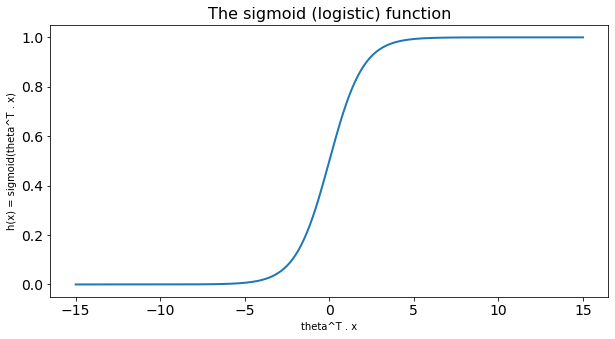

In [13]:
# This has been provided for simplicity, but you should test some outputs. You should find that it works with arrays as well as numbers, and that large negative numbers -> 0,
# and large positive numbers -> 1

def sigmoid(z):
    
    g = 1.0/(1.0 + np.exp(-z))
    
    return g

print(sigmoid(np.array([-10, -1, 0, 1, 10])))
plotSigmoid()

## 1. Complete the cost function

The very first step in the logistic regression algorithm is to initialize some values for your parameters (commonly this will just be zeroes). But the next step is to calculate the cost of this model, at those parameters, when fitted to the training data. And this is what you are now going to do below.

Remember, the cost function is of the form: <br>

**J(theta) = -1/m * (SUM_i:m(y_i*log(hyp(x_i)) + (1-y_i)log(1-hyp(x_i))) + lambda/2m * SUM_j:n(theta_j^2)**, <br> where i=1:m are all training examples, j=1:n are all features (excluding the bias, i.e. the first feature, j_0), and hyp(x_i) is our prediction for training example i (i.e. sigmoid(theta^T.x)).

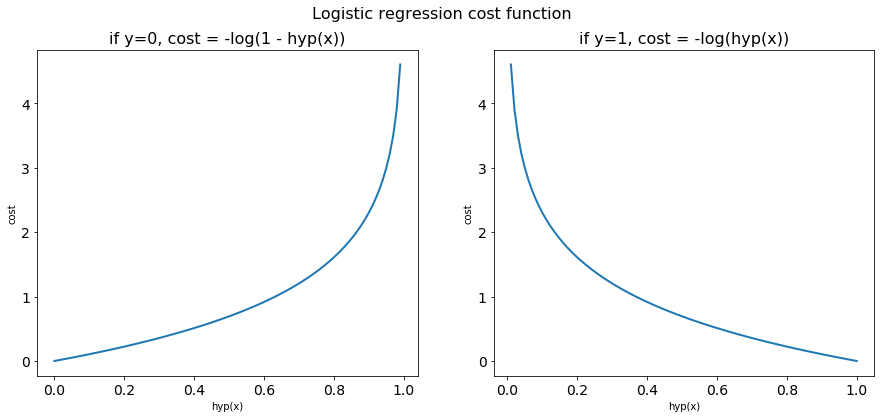

In [14]:
plotCostFunc()

In [15]:
def costFunctionReg(theta, X, y, lambda_reg):

    # num training examples
    m = len(y)

    # You need to calculate the cost and regularization term
    J = 0
    reg_term = 0
    
    ##### PART 1: Calculate the cost, J without the reg term #####
    
    # calculate the unregulated cost term
    hypothesis_vec = sigmoid(np.dot(X, theta))
    J_unreg = sum((-1*y)*np.log(hypothesis_vec) - (1-y)*np.log(1 - hypothesis_vec))/m
    
    
    # CHECK YOUR CODE BY RUNNING AGAINST THE TEST SET WITH LAMBDA=0
    
    
    ##### PART 2: Calculate the reg term and add it to J #####
    
    # add in L2 regularization ('Ridge Regularization')
    theta[0] = 0
    reg_term = np.dot(theta.T, theta) * (lambda_reg/(2*m))
    
    # total cost
    J = J_unreg + reg_term
    
    return J

## Test your cost function

When you think you have working code for part 1, you can test your results against my own. To test part 1, run this function with lambda=0. When you're ready to test your code with the regularization term, I've provided test cases for lambda = 0, 1, 10, 100, and 1000 (you'll get an error if you try anything else).

In [16]:
# choose lambda = 0, 1, 10, 100, or 1000 (anything else will give an error)

### ADJUST THIS PARAM ###
lambda_reg = 10
#########################
        
testCostFunction(lambda_reg)

Compare outputs from the cost function at lambda=10: 

Geo: 0.62175; Yours: 0.62175
Geo: 0.58891; Yours: 0.58891
Geo: 0.5282; Yours: 0.5282
Geo: 0.51029; Yours: 0.51029
Geo: 0.49858; Yours: 0.49858
Geo: 0.49845; Yours: 0.49845


## 2. Complete the partial derivatives function (gradientReg)

Now that you've got a working cost function, you need to calculate the partial derivatives of the cost function with respect to each parameter. Again, this can be done in two parts, first, without the regularization component, and then with. You can test your function against my own below (same as for the cost).

Your function should return an array, grad, with lenth=number of parameters.

In [17]:
def gradientReg(theta, X, y, lambda_reg):
    
    ##### PART 1: Calculate the partial derivs for each parameter #####
    
    # num training examples
    m = len(y)
    
    # calculate unregularized term of the partial derivs
    hypothesis_vec = sigmoid(np.dot(X, theta))
    grad = np.dot((hypothesis_vec - y).T, X)
    grad = grad * (1/m)
    
    # CHECK YOUR CODE BY RUNNING AGAINST THE TEST SET WITH LAMBDA=0
    
    ##### PART 2: include the reg term #####
    
    # add in the regularized terms
    theta[0] = 0 # do not regularize first term
    grad = grad + (theta * (lambda_reg/m))

    return grad # should be a vector with length equal to the number of parameters

## Test your partial derivative function (gradientReg)

This is the same as before. You can test for your gradient function without regularization (i.e. at lambda=0), and at lambda=1, 10, 100, aqnd 1000.

In [18]:
# choose lambda = 0, 1, 10, 100, or 1000 (anything else will give an error)

### ADJUST THIS PARAM ###
lambda_reg = 1000
#########################
        
testGradFunction(lambda_reg)

Compare outputs from the partial derivative (grad) function at lambda=1000: 

Geo: 114.30384; Yours: 114.30384
Geo: -59.96628; Yours: -59.96628
Geo: -72.87377; Yours: -72.87377
Geo: 1.74338; Yours: 1.74338
Geo: -8.84228; Yours: -8.84228
Geo: -8.84228; Yours: -8.84228


## Gradient descent

Now we have the components required for gradient descent, we just have to do it. However, as the code for implementing optimizers is not really very interesting, I've just done this for you (see below). But anyway, after running the optimizer, we don't get our predictions, just our optimum parameters for the generalised linear model (i.e., we've found values for theta that minimize the cost, and we've done this using the partial derivatives). Or in Scikit-learn language, we've just done our .fit(). Now, we need to do our .predict(), and for this, you need to complete the final function (see further below).

In [19]:
# this function is actually doing the gradient descent

def optimizeTheta(initial_theta, X, y, lambda_reg):
    
    solution = opt.fmin_tnc(func=costFunctionReg, x0=initial_theta, fprime=gradientReg, args=(X, y, lambda_reg))
    theta_fit = solution[0]
    iterations = solution[1]
    
    return theta_fit, iterations

## 3. Predict the class labels (1 or 0)

Complete the function below. If the hypothesis for a given training example is 0.5 or more, assign it 1, otherwise, assign it 0.

I.e.: <br>
if hyp(xi)>=0.5, y_pred=1 <br>
if hyp(xi)< 0.5, y_pred=0

You should return a list of predictions with length = number of training examples

In [20]:
def predict(theta, X):
    
    probability = sigmoid(np.dot(X, theta))
    predictions = [1 if x >= 0.5 else 0 for x in probability]
    return predictions

**Please just run these cells and skip to the next section. You can take a look at them later, but let's run our models first!**

In [42]:
# provided a classification accuracy function for simplicity
def classificationAccuracy(y_actual, y_hypothesis):
    correct = []
    for y_act, y_hyp in zip(y_actual, y_hypothesis):
        if int(y_act)==int(y_hyp):
            correct.append(1)
        else:
            correct.append(0)
    
    accuracy = sum(correct)/len(correct)
    return accuracy

# also provided this ugly function. It just uses all of the functions that you've made to fit a logistic regression classifier, and it compares the results to SK-learn
def fitAllModels(X_train, y_train, X_test, y_test, lambda_reg):
    
    ### RUN OUR IMPLEMENTATION OF THE LOGISTIC REGRESSION ALGORITHM ###
    
    # Initialize fitting parameters
    _, j = X_train.shape
    theta = np.zeros((j,))
    
    # minimize the cost function (this is our .fit() using the Scikit-learn package)
    theta_fit, iterations = optimizeTheta(theta, X_train, y_train, lambda_reg)

    # get accuracy scores for the test set
    y_test_pred = predict(theta_fit, X_test)
    accuracy_test = classificationAccuracy(y_test, y_test_pred)

    # same again for the train
    y_train_pred = predict(theta_fit, X_train)
    accuracy_train = classificationAccuracy(y_train, y_train_pred)

    # calculate the cost at the optimum theta values
    J_train = costFunctionReg(theta_fit, X_train, y_train, lambda_reg)

    print(f'Our logistic regression accuracy for train: {round(accuracy_train*100)}%, and for test: {round(accuracy_test*100)}%. Solution found in {iterations} iterations.')

    ### CHECK AGAINST SK-LEARN ###
    
    # you can think of C as inversely proportional to lambda (it's a formalism usually used with SVMs, but with SK-learn they also use it with the log reg package)
    C_param = 1/lambda_reg if lambda_reg>0 else 1_000_000 #<- this ensures we don't accidentally divide by zero

    # C is our regularization param; and we do not need to add the bias (as we have already done this manually by adding ones to X)
    LR_model = LogisticRegression(C=C_param, solver='liblinear', penalty='l2', max_iter=1000, fit_intercept=False) 
    LR_model.fit(X_train, y_train)
    theta_SK = LR_model.coef_
    theta_SK = theta_SK.T.reshape(-1)
    iterations_SK = LR_model.n_iter_[0]
    y_pred_test_SK = LR_model.predict(X_test)
    y_pred_train_SK = LR_model.predict(X_train)

    accuracy_test_SK = classificationAccuracy(y_test, y_pred_test_SK)
    accuracy_train_SK = classificationAccuracy(y_train, y_pred_train_SK)

    # calculate the cost at the optimum theta val from SK-learn
    J_train_SK = costFunctionReg(theta_SK, X_train, y_train, lambda_reg)

    print(f'SK-learn accuracy for train:                {round(accuracy_train_SK*100)}%, and for test: {round(accuracy_test_SK*100)}%. Solution found in {iterations_SK} iterations.')
    print('\n')
    print(f' Cost from our log reg: {round(J_train, 5)}', '\n', f'Cost from SK-learn:    {round(J_train_SK, 5)}')

# Run the model

We have everything in place now to both train and evaluate our logistic regression model. Let's run it and compare the results against Sci-kit learn's implementation.

In [43]:
### CHOOSE ANY LAMBDA AND THEN RUN ###
lambda_reg = 50000

fitAllModels(X_train, y_train, X_test, y_test, lambda_reg)

Our logistic regression accuracy for train: 68%, and for test: 65%. Solution found in 131 iterations.
SK-learn accuracy for train:                68%, and for test: 65%. Solution found in 15 iterations.


 Cost from our log reg: 0.60056 
 Cost from SK-learn:    0.60038


In [23]:
# # implementing logistic regression with for-loops

# def costFunctionReg_loop(theta, X, y, lambda_reg):
    
#     # num training examples
#     m = len(y)
    
#     # You need to return the following variables correctly
#     J = 0
    
#     # calculate the unregulated cost term
#     J_unreg = 0
#     for i in range(m):
        
#         # x_i, y_i, and y_pred (hypothesis)
#         x_i = X[i,:]
#         y_i = y[i]
#         hypothesis_i = sigmoid(np.dot(x_i, theta))
        
#         J_unreg_i = ((-1*y_i)*np.log(hypothesis_i)) - ((1 - y_i)*(np.log(1 - hypothesis_i)))
#         J_unreg += J_unreg_i
        
#     J_unreg = J_unreg/m # when out of loop, take average
    
#     # calculate the regularization term
#     reg_term = 0
#     for i, theta_j in enumerate(theta):
#         # skip the bias term
#         if i==0:
#             continue 
#         reg_term = reg_term + theta_j**2
        
#     # moderate the reg term with lambda (the regularization parameter)
#     reg_term = (lambda_reg/(2*m)) * reg_term
    
#     # total cost
#     J = J_unreg + reg_term
    
#     return J

In [24]:
# # Initialize some parameters for testing
# _, j = X_train.shape
# theta_test = np.ones((j,))*0.000000000001
# lambda_reg = 0.0000000000001

# print(costFunctionReg(theta_test, X_train, y_train, lambda_reg))
# print(costFunctionReg_loop(theta_test, X_train, y_train, lambda_reg))

In [25]:
# # Initialize some parameters for testing
# _, j = X_train.shape
# theta_test = np.ones((j,))*0.000000000001
# lambda_reg = 100000000000

# print(costFunctionReg(theta_test, X_train, y_train, lambda_reg))
# print(costFunctionReg_loop(theta_test, X_train, y_train, lambda_reg))


In [26]:
# # check that your cost function works (without regularization, i.e. lambda=0)

# # Initialize some parameters for testing
# _, j = X_train.shape
# theta_test = np.zeros((j,))
# lambda_reg = 1000

# # load theta and cost for lambda 0
# theta_filename = 'theta_lambda' + str(lambda_reg) + '.txt'
# cost_filename = 'cost_lambda' + str(lambda_reg) + '.txt'
# parameters_mat = np.loadtxt(theta_filename, delimiter=',')
# cost_ary = np.loadtxt(cost_filename, delimiter=',')

# print(f'Compare results at lambda={lambda_reg}:', '\n')

# for i in range(parameters_mat.shape[0]):
    
#     theta_test = parameters_mat[i,:]
#     cost_Geo = cost_ary[i]
    
#     cost_our = costFunctionReg(theta_test, X_train, y_train, lambda_reg)
    
    
#     print(f'Geo: {round(cost_Geo, 5)}; Yours: {round(cost_our, 5)}')

In [27]:
# def gradientReg(theta, X, y, lambda_reg):
    
#     ##### PART 2: Calculate the partial derivs for each parameter #####
    
#     # num training examples
#     m = len(y)
    
#     # calculate unregularized term of the partial derivs
#     hypothesis_vec = sigmoid(np.dot(X, theta))
#     grad = np.dot((hypothesis_vec - y).T, X)
#     grad = grad * (1/m)
    
#     # add in the regularized terms
#     theta[0] = 0 # do not regularize first term
#     grad = grad + (theta * (lambda_reg/m))

#     return grad

In [28]:
# def gradientReg(theta, X, y, lambda_reg):
    
#     ##### PART 2: Calculate the partial derivs for each parameter #####
    
#     # num training examples
#     m = len(y)
    
#     # calculate unregularized term of the partial derivs
#     hypothesis_vec = sigmoid(np.matmul(X, theta))
#     grad = np.matmul(np.transpose(hypothesis_vec - y), X)
#     grad = grad * (1/m)
    
#     # add in the regularized terms
#     theta[0] = 0 # do not regularize first term
#     grad = grad + (theta * (lambda_reg/m))

#     return grad

# def optimizeTheta(initial_theta, X, y, lambda_reg):
    
#     solution = opt.fmin_tnc(func=costFunctionReg, x0=initial_theta, fprime=gradientReg, args=(X, y, lambda_reg))
#     theta_fit = solution[0]
#     iterations = solution[1]
    
#     return theta_fit, iterations

# def optimizeTheta_maxIter(initial_theta, X, y, lambda_reg, max_iter):
    
#     solution = opt.fmin_tnc(func=costFunctionReg, x0=initial_theta, fprime=gradientReg, args=(X, y, lambda_reg), maxfun=max_iter)
#     theta_fit = solution[0]
#     iterations = solution[1]
    
#     return theta_fit, iterations

# def predict(theta, X):
    
#     probability = sigmoid(np.dot(X, theta))
#     predictions = [1 if x >= 0.5 else 0 for x in probability]
#     return predictions

# def classificationAccuracy(y_actual, y_hypothesis):
#     correct = []
#     for y_act, y_hyp in zip(y_actual, y_hypothesis):
#         if int(y_act)==int(y_hyp):
#             correct.append(1)
#         else:
#             correct.append(0)
    
#     accuracy = sum(correct)/len(correct)
#     return accuracy

In [29]:
# # check that 

# max_iters = [5, 10, 20, 40, 80]

In [30]:
# # Initialize fitting parameters
# _, j = X_train.shape
# initial_theta = np.zeros((j,))
# # set lambda_reg
# lambda_reg = 0

# fitAllModels(initial_theta, X_train, y_train, X_test, y_test, lambda_reg)

# def fitAllModels(theta, X_train, y_train, X_test, y_test, lambda_reg):
    
#     # Initialize fitting parameters
#     _, j = X_train.shape
#     initial_theta = np.zeros((j,))
    
#     # minimize the cost function (this is our .fit() using the Scikit-learn package)
#     theta_fit, iterations = optimizeTheta(theta, X_train, y_train, lambda_reg)

#     # get accuracy scores for train and test
#     y_test_pred = predict(theta_fit, X_test)
#     accuracy_test = classificationAccuracy(y_test, y_test_pred)

#     y_train_pred = predict(theta_fit, X_train)
#     accuracy_train = classificationAccuracy(y_train, y_train_pred)

#     # calculate the cost at the optimum theta val
#     J_train = costFunctionReg(theta_fit, X_train, y_train, lambda_reg)

#     print(f'Our logistic regression accuracy for train: {round(accuracy_train*100)}%, and for test: {round(accuracy_test*100)}%. Solution found in {iterations} iterations.')

#     # check against SK-learn

#     # you can think of C as inversely proportional to lambda (it's a formalism usually used with SVMs, but with SK-learn they also use it with the log reg package)
#     C_param = 1/lambda_reg if lambda_reg>0 else 1_000_000 #<- this ensures we don't accidentally divide by zero

#     LR_model = LogisticRegression(C=C_param, solver='liblinear', penalty='l2', max_iter=1000, fit_intercept=False) # C is our regularization param; and we do not need to add the bias (as we have already done this manually by adding ones to X)
#     LR_model.fit(X_train, y_train)
#     theta_SK = LR_model.coef_
#     theta_SK = theta_SK.T.reshape(-1)
#     iterations_SK = LR_model.n_iter_[0]
#     y_pred_test_SK = LR_model.predict(X_test)
#     y_pred_train_SK = LR_model.predict(X_train)

#     accuracy_test_SK = classificationAccuracy(y_test, y_pred_test_SK)
#     accuracy_train_SK = classificationAccuracy(y_train, y_pred_train_SK)

#     # calculate the cost at the optimum theta val from SK-learn
#     J_train_SK = costFunctionReg(theta_SK, X_train, y_train, lambda_reg)

#     print(f'SK-learn accuracy for train:                {round(accuracy_train_SK*100)}%, and for test: {round(accuracy_test_SK*100)}%. Solution found in {iterations_SK} iterations.')
#     print('\n')
#     print(f' Cost from our log reg: {round(J_train, 5)}', '\n', f'Cost from SK-learn:    {round(J_train_SK, 5)}')

In [31]:
# # Initialize fitting parameters
# _, j = X_train.shape
# initial_theta = np.zeros((j,))

# # set lambda_reg
# lambda_reg = 0

# # minimize the cost function (this is our .fit() using the Scikit-learn package)
# theta_fit, iterations = optimizeTheta(initial_theta, X_train, y_train, lambda_reg)

# # get accuracy scores for train and test
# y_test_pred = predict(theta_fit, X_test)
# accuracy_test = classificationAccuracy(y_test, y_test_pred)

# y_train_pred = predict(theta_fit, X_train)
# accuracy_train = classificationAccuracy(y_train, y_train_pred)

# # calculate the cost at the optimum theta val
# J_train = costFunctionReg(theta_fit, X_train, y_train, lambda_reg)

# print(f'Our logistic regression accuracy for train: {round(accuracy_train*100)}%, and for test: {round(accuracy_test*100)}%. Solution found in {iterations} iterations.')

# # check against SK-learn

# # you can think of C as inversely proportional to lambda (it's a formalism usually used with SVMs, but with SK-learn they also use it with the log reg package)
# C_param = 1/lambda_reg if lambda_reg>0 else 1_000_000 #<- this ensures we don't accidentally divide by zero

# LR_model = LogisticRegression(C=C_param, solver='liblinear', penalty='l2', max_iter=1000, fit_intercept=False) # C is our regularization param; and we do not need to add the bias (as we have already done this manually by adding ones to X)
# LR_model.fit(X_train, y_train)
# theta_SK = LR_model.coef_
# theta_SK = theta_SK.T.reshape(-1)
# iterations_SK = LR_model.n_iter_[0]
# y_pred_test_SK = LR_model.predict(X_test)
# y_pred_train_SK = LR_model.predict(X_train)

# accuracy_test_SK = classificationAccuracy(y_test, y_pred_test_SK)
# accuracy_train_SK = classificationAccuracy(y_train, y_pred_train_SK)

# # calculate the cost at the optimum theta val from SK-learn
# J_train_SK = costFunctionReg(theta_SK, X_train, y_train, lambda_reg)

# print(f'SK-learn accuracy for train:                {round(accuracy_train_SK*100)}%, and for test: {round(accuracy_test_SK*100)}%. Solution found in {iterations_SK} iterations.')
# print('\n')
# print(f' Cost from our log reg: {round(J_train, 5)}', '\n', f'Cost from SK-learn:    {round(J_train_SK, 5)}')

In [32]:
# # re-do the train test split and assign predicted labels for plotting
# X_train_plot, X_test_plot, y_train_plot, y_test_plot = train_test_split(df, y, test_size=0.3, random_state=66)

# X_train_plot['predictions_binary'] = list(y_train_pred)
# X_test_plot['predictions_binary'] = list(y_test_pred)

# X_train_plot['predictions'] = X_train_plot['predictions_binary'].apply(lambda x: 'paintStripper' if x==0 else 'midShelf')
# X_test_plot['predictions'] = X_test_plot['predictions_binary'].apply(lambda x: 'paintStripper' if x==0 else 'midShelf')

In [33]:
# sns.set_context("paper", rc={"axes.labelsize":16})
# g = sns.pairplot(X_test_plot.drop(['quality', 'class_binary', 'class', 'predictions_binary'], axis=1), kind='scatter', hue='predictions', markers=["o", "s"], corner=True,
#             plot_kws={'alpha':0.4})
# handles = g._legend_data.values()
# g.fig.legend(fontsize = 26, title = 'Predictions', title_fontsize = 26, handles=handles, labels=['Paint stripper', 'Mid-shelf'], loc='upper center', ncol=2)
# plt.show()

In [34]:
# # plot the sigmoid function

# x_axis = np.linspace(-15, 15, 500)
# y_sigmoid = sigmoid(x_axis)

# plt.rc('xtick', labelsize=14) 
# plt.rc('ytick', labelsize=14) 

# plt.figure(figsize=(10,5))
# plt.plot(x_axis, y_sigmoid, 'tab:blue', linewidth=2)
# plt.xlabel('theta^T . x')
# plt.ylabel('h(x) = sigmoid(theta^T . x)')
# plt.title('The sigmoid (logistic) function', fontsize=16)

# plt.show()

In [35]:
# # plot of cost function

# x_axis = np.linspace(0,1,101)
# y_when_1 = -1*(np.log(x_axis))
# y_when_0 = -1*(np.log(1 - x_axis))

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
# fig.suptitle('Logistic regression cost function', fontsize=16)
# ax1.plot(x_axis, y_when_0, 'tab:blue', linewidth=2)
# ax2.plot(x_axis, y_when_1, 'tab:blue', linewidth=2)
# ax1.set_title('if y=0, cost = -log(1 - hyp(x))', fontsize=16)
# ax2.set_title('if y=1, cost = -log(hyp(x))', fontsize=16)
# ax1.set_xlabel('hyp(x)')
# ax2.set_xlabel('hyp(x)')
# ax1.set_ylabel('cost')
# ax2.set_ylabel('cost')

# plt.show()

In [36]:
# # implementing logistic regression with for-loops

# def costFunctionReg_loop(theta, X, y, lambda_reg):
    
#     # num training examples
#     m = len(y)
    
#     # You need to return the following variables correctly
#     J = 0
#     grad = np.zeros(theta.shape)
    
#     # calculate the unregulated cost term
#     J_unreg = 0
#     for i in range(m):
        
#         # x_i, y_i, and y_pred (hypothesis)
#         x_i = X[i,:]
#         y_i = y[i]
#         hypothesis_i = sigmoid(np.matmul(x_i, theta))
        
#         J_unreg_i = ((-1*y_i)*np.log(hypothesis_i)) - ((1 - y_i)*(np.log(1 - hypothesis_i)))
#         J_unreg += J_unreg_i
        
#     J_unreg = J_unreg/m # when out of loop, take average
    
#     # calculate the regularization term
#     reg_term = 0
#     for i, theta_j in enumerate(theta):
#         # skip the bias term
#         if i==0:
#             continue 
#         reg_term = reg_term + theta_j**2
        
#     # moderate the reg term with lambda (the regularization parameter)
#     reg_term = (lambda_reg/(2*m)) * reg_term
    
#     # total cost
#     J = J_unreg + reg_term
    
#     return J, grad

In [37]:
# # Initialize fitting parameters
# _, j = X_train.shape
# initial_theta = np.zeros((j,))
# # set lambda_reg
# lambda_reg = 1000

# max_iters = [5, 10, 20, 40, 80]
# Theta_mat = np.zeros((len(max_iters)+1, j))
# grad_mat = np.zeros((len(max_iters)+1, j))
# J_ary = np.zeros((len(max_iters)+1, ))

# for i, max_iter in enumerate(max_iters):
    
#     # minimize the cost function up to max iter
#     theta_fit, iterations = optimizeTheta_maxIter(initial_theta, X_train, y_train, lambda_reg, max_iter)
#     Theta_mat[i, :] = theta_fit
    
#     # calculate the cost
#     cost = costFunctionReg(theta_fit, X_train, y_train, lambda_reg)
#     J_ary[i,] = cost
    
#     # calculate the gradient
#     grad = gradientReg(theta_fit, X_train, y_train, lambda_reg)
#     grad_mat[i, :] = grad

# # minimize the cost function 
# theta_fit, iterations = optimizeTheta(initial_theta, X_train, y_train, lambda_reg)
# Theta_mat[len(max_iters), :] = theta_fit
# # print(Theta_mat)

# # calculate the cost
# cost = costFunctionReg(theta_fit, X_train, y_train, lambda_reg)
# J_ary[len(max_iters)] = cost
# # print(J_ary)

# # calculate the grad
# grad = gradientReg(theta_fit, X_train, y_train, lambda_reg)
# grad_mat[len(max_iters), :] = grad
    
# np.savetxt('theta_lambda1000.txt', Theta_mat, delimiter=',')   
# np.savetxt('cost_lambda1000.txt', J_ary, delimiter=',')   
# np.savetxt('grad_lambda1000.txt', grad_mat, delimiter=',')